In [16]:
import numpy as np 
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import datetime

In [17]:
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/churchland.npy') 
X = jnp.array(X) 
K, N, T = X.shape
print(X.shape)

(108, 218, 61)


In [18]:
def soft_normalize(X):
    X_norm_const = jnp.maximum(jnp.max(X, axis=(0,2),  keepdims=True ), 0.1)
    X_normalized = X / X_norm_const
    mean_across_conditions = jnp.mean(X_normalized, axis=0, keepdims=True) 
    X_normalized = X_normalized - mean_across_conditions
    return X_normalized


Iteration 0, S: 1.990936340234839e-07
Iteration 10, S: 2.7617329578788485e-07
Iteration 20, S: 2.3464779985715722e-07
Iteration 30, S: 1.2573664776027726e-07
Iteration 40, S: 2.71227747816738e-07
Iteration 50, S: 8.2292579861587e-08
Iteration 60, S: 3.413924503092858e-07
Iteration 70, S: 2.027814360872071e-07
Iteration 80, S: 2.232710585303721e-07
Iteration 90, S: 5.050588356425578e-07
Iteration 100, S: 5.067585675533337e-07
Iteration 110, S: 6.679577069235165e-08
Iteration 120, S: 5.525885740098602e-07
Iteration 130, S: 2.577046700480423e-07
Iteration 140, S: 3.260120138293132e-07
Iteration 150, S: 1.0792784905788722e-06
Iteration 160, S: 6.889640644658357e-07
Iteration 170, S: 8.458455340587534e-07
Iteration 180, S: 9.135783329838887e-07
Iteration 190, S: 1.1346991186655941e-06
Iteration 200, S: 6.259362521632283e-07
Iteration 210, S: 1.9354381493030814e-06
Iteration 220, S: 1.9117780993838096e-06
Iteration 230, S: 2.7932740067626582e-06
Iteration 240, S: 3.1892780043563107e-06
Itera

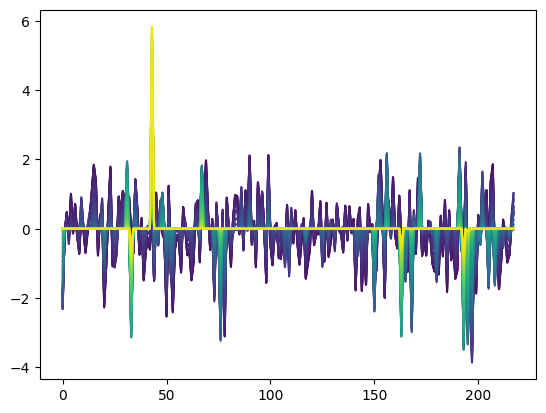

In [43]:
def single_pair_loss(U_tilde, X, id_1, id_2):                           #U (N,d); X(K,N,T)

    Y = jnp.einsum('ji,jk->ik', U_tilde, X[id_1, :, :])                 #(d,T)
    Y_prime = jnp.einsum('ji,jk->ik', U_tilde, X[id_2, :, :])           #(d,T)

    YY = jnp.einsum('ij,kj->ik', Y, Y_prime)                            #(d,d)
    YY_product = jnp.einsum('ij,lm->im', YY, YY)                        #(d,d)

    S_pair = jnp.trace(YY)**2 - jnp.trace(YY_product)
    return S_pair

def loss(params, X, key, s_learn):  
    K, N, T = X.shape
    if s_learn:
        U = params['U_dict']
        s = params['s_dict'] 

        l2_norm = jnp.linalg.norm(s)
        s_normalized = s / l2_norm
        X_scaled = s_normalized[None, :, None] * X
    else:
        U = params
        X_scaled = X
    
    U_tilde, _ = jnp.linalg.qr(U)

    num_pairs = 10  
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=N)
    index_pairs = indices.reshape((num_pairs, 2))

    batched_loss = vmap(single_pair_loss, in_axes=(None, None, 0, 0))(U_tilde, X_scaled, index_pairs[:, 0], index_pairs[:, 1]) #(num_pairs)

    S = (2 / (K**2) ) * jnp.sum(batched_loss)
    return -S

def update_U(params, X, optimizer, opt_state, key, s_learn):
    dL_dU = grad(loss)(params,X,key, s_learn)
  
    updates, opt_state_updated = optimizer.update(dL_dU, opt_state, params)
    params_updated = optax.apply_updates(params, updates)
    return params_updated, opt_state_updated

def optimize_U(X, s_learn=False, iterations=4000, learning_rate=0.001, d=3, seed=42):
    K, N, T = X.shape
    key = random.PRNGKey(seed)
    
    U = random.normal(key, (N, d))
    s = random.normal(key, (N,)) 

    if s_learn:
        params = {
            'U_dict': U,
            's_dict': s
        }
    else: 
        params = U 

    keys = random.split(key, num=iterations)

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    
    ls_loss = []
    cmap = plt.get_cmap('viridis')
    for i in range(iterations):
        params, opt_state = update_U(params, X, optimizer, opt_state, keys[i], s_learn)
        ls_loss.append(loss(params, X, keys[i], s_learn))
        
        if i % 10 == 0:
            print(f"Iteration {i}, S: {-loss(params, X, keys[i], s_learn)}")
            
        if i % 100 == 0:
            plt.plot(params['s_dict'], color=cmap(i / (iterations - 1)))
    
    
    return params, ls_loss

s_learn = True
optimized_params, ls_loss = optimize_U(soft_normalize(X), s_learn)                     #optimized_U (N,d)

now = datetime.datetime.now()
date_time_str = now.strftime('%d%m%Y_%H%M%S')

save_path_U = 'outputs/linear_sca/optimized_U_linear_SCA/optimized_U_' + date_time_str

if s_learn:
    optimized_U = optimized_params['U_dict']
    np.save(save_path_U, optimized_U)

    optimized_s = optimized_params['s_dict']
    save_path_s = 'outputs/linear_sca/optimized_U_linear_SCA/optimized_s_' + date_time_str
    np.save(save_path_s, optimized_s)
else:
    optimized_U = optimized_params
    np.save(save_path_U, optimized_U)

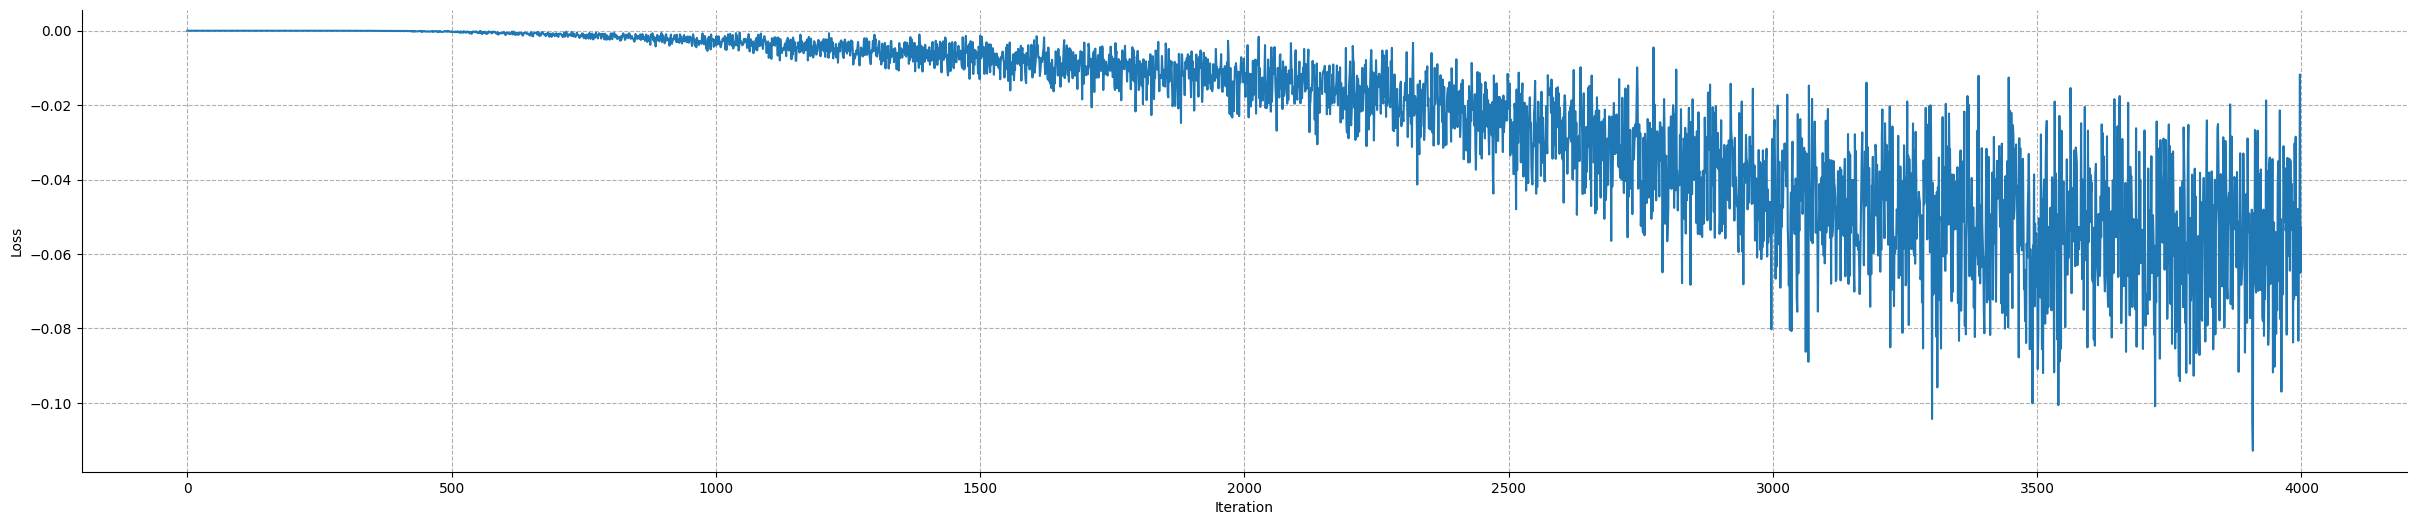

In [44]:
plt.figure(figsize=(30, 6))
plt.plot(ls_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, which="both", ls="--") 
plt.gca().spines[['right', 'top']].set_visible(False)


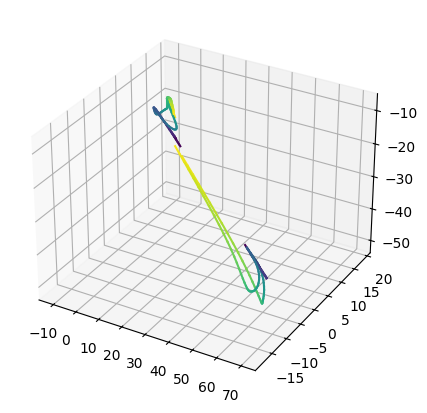

In [69]:
threshold = 0.025
mask = jnp.abs(optimized_s) > threshold
indices = jnp.where(mask)[0]
print(indices)

optimized_U_tilde, _ = jnp.linalg.qr(optimized_U)        
Y = jnp.einsum('ji,kjl->kil', optimized_U_tilde[indices,:], X[:,indices,:])         #(K,d,T)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('viridis')

num_time_points = Y.shape[-1]
indices_to_plot = np.arange(0,Y.shape[0],1)

for i in indices_to_plot:
    x = Y[i, 0, :]  
    y = Y[i, 1, :] 
    z = Y[i, 2, :]  
    
    for t in range(num_time_points - 1):
        ax.plot(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1)))


In [63]:
def make_frame(angle):
    ax.view_init(30, angle)
    fig.canvas.draw() 
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

angles = range(0, 360, 2) 
frames = [make_frame(angle) for angle in angles]

gif_path = date_time_str + "_trajectories_rotation_test.gif"
imageio.mimsave(gif_path, frames, fps=20)

gif_path

/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_80670/105152096.py:4: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


'16052024_123710_trajectories_rotation_test.gif'